In [20]:
!pip -q install lightkurve 
!pip -q install astropy

In [21]:
import numpy as np
import polars as pl
import polars.selectors as cs
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import pandas as pd
import pandas as pd, numpy as np, re

# Prétraitement & vues multi-résolution

## Récupération de la donnée / Filtrage

Avant d’appliquer le pipeline de prétraitement (dé-trending spline/GP, sigma-clipping 5σ, normalisation médiane / IQR, uniformisation de cadence), il faut savoir où sont le temps, le flux, et les flags dans le CSV. 

Comment faire ?

Création d'une pipeline générique. Nous allons créer un dictionnaire pour rendre la recherche insensible à la casse (ex : "time"->"TIME").
Puis comme les CSV astronomiques n'ont pas tous les mêmes entêtes on augmentente la robustesse en récupéreant les colonnes par mot clés.



## Dé-trending longue échelle 

### Aides statistiques robustes
Objectif : obtenir une courbe propre, centrée, régulière, où les petites baisses utiles ne sont pas écrasées.

Def mad (Médian absolute deviation) et IQR (écart interquartile) : ignorent l'influence des gros pics avec une dispersion basées sur les quantiles
(permet de garder un seuil réaliste pour repérer les vrais point anormaux )

Def robust_sigma : Sert à traduire MAD en “σ” robuste compatible. 
/!\ 1,4826 = 1 / 0,6745 
donc 1,4826 * 0,6745  ≈  1 

A savoir 1,4826 est une constante théorique qui vient de la loi normale standard ;)
(permet de corrigé la mad pour qu'il soit "équivalent à un écart type classique)

### Sigma-clipping itératif

In [23]:
# ============================================
# TESS Light Curve — Detrend & Cleaning & Resampling (Kaggle-ready)
# ============================================
import numpy as np, pandas as pd, warnings
from dataclasses import dataclass
from typing import Tuple, Optional, Dict, List
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ---------- Utils ----------
def infer_time_flux_columns(df: pd.DataFrame,
                            prefer_time: str | None = None,
                            prefer_flux: str | None = None) -> tuple[str, str]:
    """
    Infère les colonnes temps/flux.
    - Reconnaît les variantes TESS/Kepler: time_bjd_tdb, btjd/tbjd/bkjd/bjd/jd/mjd/time, etc.
    - Flux: flux_norm, pdcsap_flux, sap_flux, flux, flux_raw/flux_corrected, f...
    - Si prefer_* fourni et présent, il est utilisé en priorité.
    - Fallback: 1) colonnes dont le nom contient 'time' / 'flux' et dtype numérique
               2) tentative sur colonnes numériques uniques proches.
    """
    cols = {c.lower(): c for c in df.columns}
    # 1) préférences explicites
    if prefer_time and prefer_time in df.columns:
        time_col = prefer_time
    else:
        time_candidates = [
            # très usuels TESS/Kepler
            "time_bjd_tdb", "btjd", "tbjd", "bkjd", "bjd", "jd", "mjd",
            # génériques
            "time", "t",
            # variantes vues parfois
            "time_mission", "time_btjd", "time_bkjd", "time_bjd", "time_jd"
        ]
        time_col = next((cols[c] for c in time_candidates if c in cols), None)

    if prefer_flux and prefer_flux in df.columns:
        flux_col = prefer_flux
    else:
        flux_candidates = [
            # usuels
            "flux_norm", "pdcsap_flux", "sap_flux", "flux",
            # variantes fréquentes
            "flux_corrected", "flux_raw", "f", "flux_cal", "flux_det", "flux_lc"
        ]
        flux_col = next((cols[c] for c in flux_candidates if c in cols), None)

    # 2) Fallback par motif + dtype numérique
    def _first_numeric_col_containing(substr: str):
        for c in df.columns:
            if substr in c.lower():
                try:
                    if pd.api.types.is_numeric_dtype(df[c]):
                        return c
                except Exception:
                    continue
        return None

    if time_col is None:
        time_col = _first_numeric_col_containing("time")
    if flux_col is None:
        flux_col = _first_numeric_col_containing("flux")

    # 3) Erreur si toujours rien
    if time_col is None or flux_col is None:
        raise ValueError(f"Impossible d'inférer time/flux. Colonnes vues: {list(df.columns)[:10]}")

    return time_col, flux_col


# ---------- Sigma clipping robuste ----------
def robust_sigma_clip(y: np.ndarray, sigma: float = 5.0) -> np.ndarray:
    """
    Renvoie un masque True pour les points conservés, False pour outliers.
    Estimation robuste via médiane + MAD (IQR-like).
    """
    med = np.nanmedian(y)
    mad = np.nanmedian(np.abs(y - med))
    if mad == 0 or np.isnan(mad):
        # fallback std
        std = np.nanstd(y)
        z = (y - np.nanmean(y)) / (std if std > 0 else 1)
    else:
        # 1.4826 ~ factor to make MAD comparable to std under normality
        z = (y - med) / (1.4826 * mad)
    keep = np.isfinite(z) & (np.abs(z) <= sigma)
    return keep

# ---------- Binning pour tendance lente ----------
def bin_median(x: np.ndarray, y: np.ndarray, bin_width_days: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Binning médian pour capturer la tendance de fond sur une échelle donnée (bin_width_days).
    """
    if len(x) == 0:
        return x, y
    x0, x1 = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
        return x, y
    edges = np.arange(x0, x1 + bin_width_days, bin_width_days)
    idx = np.digitize(x, edges) - 1
    xb, yb = [], []
    for i in range(len(edges)-1):
        m = idx == i
        if m.sum() >= 3:
            xb.append(np.nanmedian(x[m]))
            yb.append(np.nanmedian(y[m]))
    return np.array(xb), np.array(yb)

# ---------- Tendance par spline cubique ----------
def fit_spline_trend(time: np.ndarray, flux: np.ndarray,
                     bin_width_hours: float = 6.0,
                     spline_smooth_factor: Optional[float] = None) -> np.ndarray:
    """
    Estime la tendance lente via:
    1) bin médian (par ex. 6h) pour lisser le bruit haute fréquence,
    2) spline cubique lissée (UnivariateSpline, k=3) ajustée sur ces points binnés,
    3) évalue la spline aux temps originaux.
    """
    # Convertir bin en jours (TESS/Kepler: temps en jours)
    bin_w_days = bin_width_hours / 24.0
    xb, yb = bin_median(time, flux, bin_w_days)

    if len(xb) < 5:
        # Pas assez de points binned -> fallback à une spline directe (ou médiane)
        med = np.nanmedian(flux)
        return np.full_like(flux, med)

    # Choix d'un facteur de lissage raisonnable s si non fourni
    # s ~ lambda * N, où lambda ~ variance résiduelle attendue
    # On met un s par défaut conservatif (proportionnel à nb de points binnés).
    if spline_smooth_factor is None:
        spline_smooth_factor = max(1e-3, 0.001 * len(xb))

    try:
        spl = UnivariateSpline(xb, yb, k=3, s=spline_smooth_factor)
        trend = spl(time)
    except Exception:
        # Fallback: moyenne mobile grossière (au cas où spline échoue)
        trend = pd.Series(flux).rolling(window=101, min_periods=1, center=True).median().values

    return trend

# ---------- Normalisation robuste ----------
def robust_scale(y: np.ndarray) -> np.ndarray:
    med = np.nanmedian(y)
    q25, q75 = np.nanpercentile(y, [25, 75])
    iqr = q75 - q25
    if not np.isfinite(iqr) or iqr == 0:
        iqr = np.nanstd(y)
        if not np.isfinite(iqr) or iqr == 0:
            iqr = 1.0
    return (y - med) / iqr

# ---------- Resampling uniforme ----------
def resample_uniform(time_days: np.ndarray,
                     flux: np.ndarray,
                     step_minutes: float = 10.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Ré-échantillonne (interpolation linéaire) sur une grille régulière de pas = step_minutes.
    Gère les NaN: on interpole seulement entre bornes valides.
    """
    if len(time_days) < 3:
        return time_days, flux

    t0, t1 = np.nanmin(time_days), np.nanmax(time_days)
    if not np.isfinite(t0) or not np.isfinite(t1) or t1 <= t0:
        return time_days, flux

    dt = step_minutes / (24.0 * 60.0)
    grid = np.arange(t0, t1 + 0.5*dt, dt)

    # Masque points valides
    m = np.isfinite(time_days) & np.isfinite(flux)
    if m.sum() < 2:
        return grid, np.full_like(grid, np.nan)

    # Tri (sécurité)
    order = np.argsort(time_days[m])
    t_sorted = time_days[m][order]
    f_sorted = flux[m][order]

    # Interp linéaire
    f_grid = np.interp(grid, t_sorted, f_sorted, left=np.nan, right=np.nan)

    return grid, f_grid

# ---------- Pipeline complet pour une courbe ----------
@dataclass
class DetrendConfig:
    sigma: float = 5.0
    bin_width_hours: float = 6.0
    spline_smooth_factor: Optional[float] = None
    resample_step_minutes: float = 10.0
    divide_trend: bool = True  # True => flux_detrended = flux / trend (puis -1), sinon flux - trend

def preprocess_single_lightcurve(df_one: pd.DataFrame, time_col: str, flux_col: str,
                                 cfg: DetrendConfig) -> Dict[str, np.ndarray]:
    # Extraire
    t = df_one[time_col].astype(float).values
    f = df_one[flux_col].astype(float).values

    # 1) Sigma clipping robuste (5σ)
    keep = robust_sigma_clip(f, sigma=cfg.sigma)
    t1, f1 = t[keep], f[keep]

    # 2) Tendance lente via spline sur binned medians
    trend = fit_spline_trend(t1, f1, bin_width_hours=cfg.bin_width_hours,
                             spline_smooth_factor=cfg.spline_smooth_factor)

    # 3) Flatten: division ou soustraction de tendance
    if cfg.divide_trend:
        # éviter division par zéro
        trend_safe = np.where(np.isfinite(trend) & (trend != 0), trend, np.nanmedian(trend))
        f_flat = (f1 / trend_safe) - 1.0
    else:
        f_flat = f1 - trend

    # 4) Normalisation robuste
    f_norm = robust_scale(f_flat)

    # 5) Resampling uniforme (10 minutes)
    t_uni, f_uni = resample_uniform(t1, f_norm, step_minutes=cfg.resample_step_minutes)

    return {
        "time_raw": t, "flux_raw": f, "mask_kept": keep,
        "time_clipped": t1, "flux_clipped": f1, "trend": trend,
        "flux_flat": f_flat, "flux_norm": f_norm,
        "time_uniform": t_uni, "flux_uniform": f_uni
    }

# ---------- Visualisation ----------
def quick_compare_plot(proc: Dict[str, np.ndarray], title: str = "", max_points: int = 100000):
    t_raw, f_raw = proc["time_raw"], proc["flux_raw"]
    t1, f1 = proc["time_clipped"], proc["flux_clipped"]
    trend = proc["trend"]
    t_uni, f_uni = proc["time_uniform"], proc["flux_uniform"]

    # downsample for speed if huge
    def thin(x, y, k=5):
        if len(x) <= max_points:
            return x, y
        step = max(1, len(x)//max_points)
        return x[::step], y[::step]

    t_raw_, f_raw_ = thin(t_raw, f_raw)
    t1_, f1_ = thin(t1, f1)
    t_uni_, f_uni_ = thin(t_uni, f_uni)

    plt.figure(figsize=(12,9))
    # A. Brut + outliers
    ax = plt.subplot(3,1,1)
    ax.plot(t_raw_, f_raw_, ".", ms=2, alpha=0.6)
    ax.set_title(f"[A] Courbe brute (avec outliers) — {title}")
    ax.set_xlabel("Temps (jours)")
    ax.set_ylabel("Flux")

    # B. Après clipping + tendance spline
    ax = plt.subplot(3,1,2)
    ax.plot(t1_, f1_, ".", ms=2, alpha=0.6, label="Clippé (5σ)")
    # évaluer la trend sur t1_ pour overlay propre
    try:
        # Interp de la tendance pour l'affichage
        tr_disp = np.interp(t1_, t1, trend, left=np.nan, right=np.nan)
        ax.plot(t1_, tr_disp, "-", lw=1.5, label="Tendance (spline)")
    except Exception:
        pass
    ax.set_title("[B] Outliers retirés + tendance lente estimée")
    ax.set_xlabel("Temps (jours)"); ax.set_ylabel("Flux")
    ax.legend(loc="best")

    # C. Flatten + normalisé + ré-échantillonné
    ax = plt.subplot(3,1,3)
    ax.plot(t_uni_, f_uni_, ".", ms=2, alpha=0.7, label="Flatten+Norm+Uniform(10min)")
    ax.set_title("[C] Dé-trend + normalisation (médiane/IQR) + cadence uniforme")
    ax.set_xlabel("Temps (jours)"); ax.set_ylabel("Flux normalisé")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

# ---------- Chargement & dispatch multi-cibles ----------
def load_tess_csv(path: str, n_rows: Optional[int] = None) -> pd.DataFrame:
    # lecture flexible (le séparateur peut être comma ou autre)
    try:
        return pd.read_csv(path, nrows=n_rows)
    except Exception:
        return pd.read_csv(path, nrows=n_rows, engine="python", sep=None)

def group_iter(df: pd.DataFrame) -> List[Tuple[str, pd.DataFrame]]:
    id_col = infer_id_column(df)
    if id_col is None:
        return [("no_id", df)]
    groups = []
    for gid, sub in df.groupby(id_col):
        groups.append((f"{id_col}={gid}", sub.sort_values(infer_time_flux_columns(df)[0])))
    return groups


Colonnes détectées: time_bjd_tdb | flux_norm

=== Traitement target_id=TIC_101230735 ===


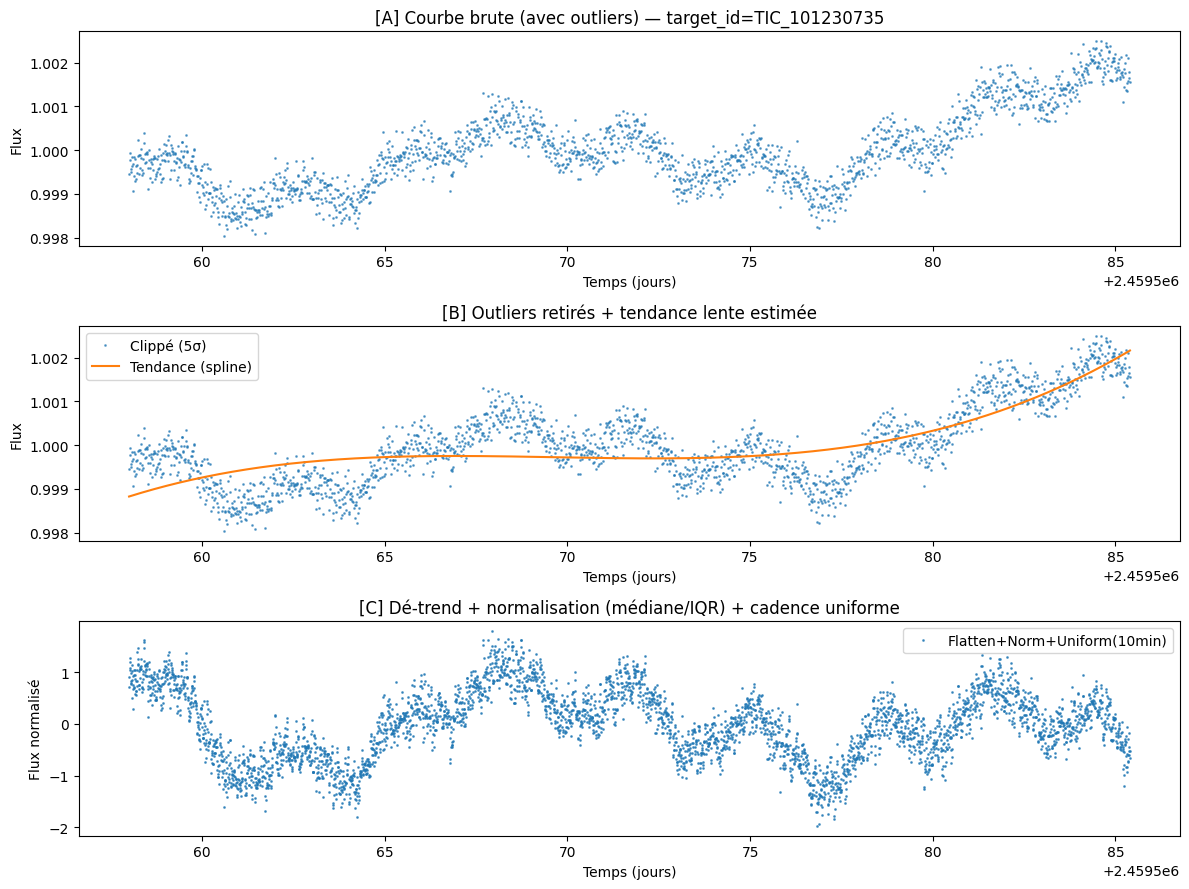


=== Traitement target_id=TIC_106997505 ===


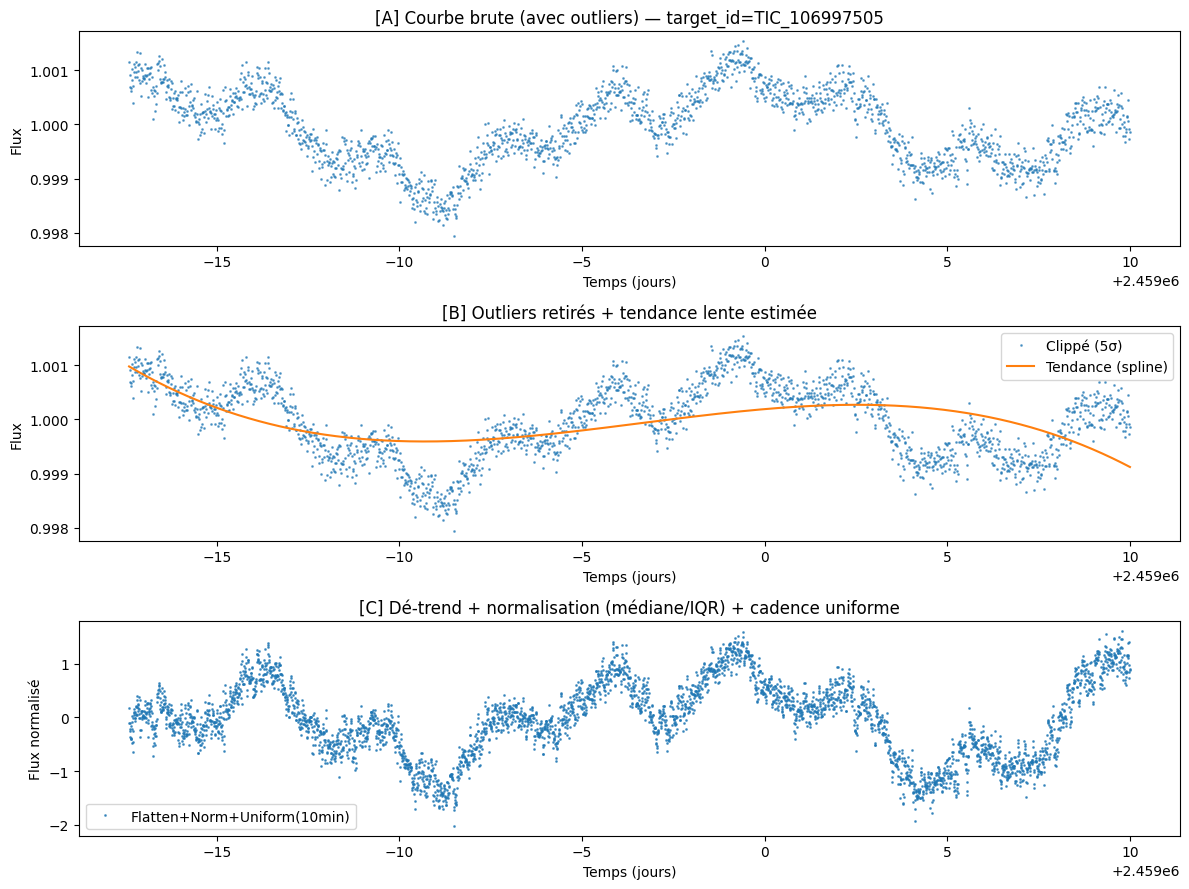


=== Traitement target_id=TIC_107782586 ===


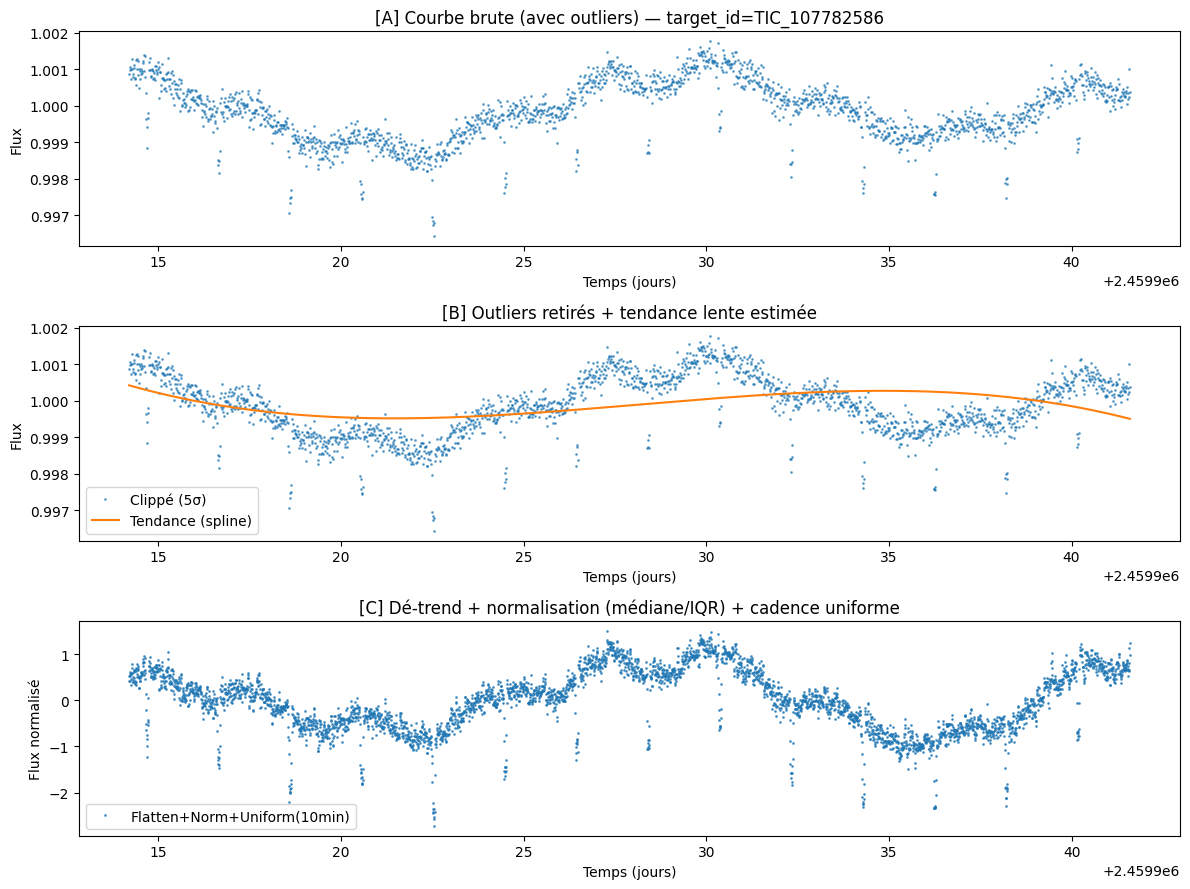

In [24]:
# -------- Exemple : charger, traiter 3 cibles, afficher avant/après --------
input_path = "/kaggle/input/tess-lightcurv/TESS_standardized_lightcurves.csv"  # <- adapte si besoin
df = load_tess_csv(input_path)

time_col, flux_col = infer_time_flux_columns(df)
print("Colonnes détectées:", time_col, "|", flux_col)

cfg = DetrendConfig(
    sigma=5.0,               # clipping robuste 5σ (pics isolés)
    bin_width_hours=6.0,     # binning 6h pour la tendance lente
    spline_smooth_factor=None, # laisse l'auto-choix raisonnable
    resample_step_minutes=10.0, # cadence uniforme 10 minutes
    divide_trend=True        # flux/Trend - 1 (flatten multiplicatif)
)

for i, (gid, sub) in enumerate(group_iter(df)):
    if i >= 3: break  # démontre sur 3 cibles
    print(f"\n=== Traitement {gid} ===")
    proc = preprocess_single_lightcurve(sub.sort_values(time_col), time_col, flux_col, cfg)
    quick_compare_plot(proc, title=gid)


## Détection de périodes candidates

In [26]:
# ==========================================================
# BLS Period Search (candidats de périodes) — Kaggle-ready
# S'appuie sur les sorties du prétraitement:
#   t = proc["time_uniform"] (jours), y = proc["flux_uniform"] (sans tendance, normalisé)
# Nécessite: astropy (installé sur Kaggle par défaut; sinon pip install astropy)
# ==========================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")
from astropy.timeseries import BoxLeastSquares


def _finite_mask(*arrs):
    m = np.ones_like(arrs[0], dtype=bool)
    for a in arrs:
        m &= np.isfinite(a)
    return m

def estimate_period_bounds(t_days: np.ndarray, min_hours: float = 7.0, max_frac_baseline: float = 0.9):
    """
    Heuristique simple:
    - période min ~ 7 h (évite d'ajuster le bruit haute fréquence)
    - période max ~ 90% de la base temporelle (évite d'atteindre le bord)
    """
    baseline_days = np.nanmax(t_days) - np.nanmin(t_days)
    p_min = max(min_hours / 24.0, 0.05)                # >= 0.05 j (≈1.2 h) en ultime secours
    p_max = max(p_min * 2, baseline_days * max_frac_baseline)
    return p_min, p_max, baseline_days

def duration_grid_hours(min_h=1.0, max_h=12.0, n=10):
    """Durées de transit testées par BLS (en heures → converties en jours)."""
    durs_h = np.geomspace(min_h, max_h, n)
    return durs_h / 24.0

def run_bls_on_proc(proc: dict,
                    n_periods: int = 5000,
                    min_period_hours: float = 7.0,
                    max_period_frac_baseline: float = 0.9,
                    durations_hours: tuple = (1.0, 12.0),
                    n_durations: int = 10,
                    top_k: int = 3):
    """
    Lance BLS (astropy) sur une courbe déjà détrendée/normalisée/ré-échantillonnée.
    Retourne dict avec:
      - 'results': DataFrame top_k candidats (period, t0, duration, depth, power, snr-like)
      - 'bls': l'objet BLS
      - 'periodogram': dict avec arrays pour plot (period, power, duration_opt, t0_opt)
    """
    t = np.asarray(proc["time_uniform"])
    y = np.asarray(proc["flux_uniform"])
    m = _finite_mask(t, y)
    t, y = t[m], y[m]

    if len(t) < 100 or (np.nanmax(t) - np.nanmin(t)) <= 0:
        raise ValueError("Série trop courte ou dégénérée pour BLS.")

    # Borne de période
    pmin, pmax, baseline_days = estimate_period_bounds(t, min_hours=min_period_hours,
                                                       max_frac_baseline=max_period_frac_baseline)
    # Durées testées
    durs = duration_grid_hours(min_h=durations_hours[0], max_h=durations_hours[1], n=n_durations)

    # Astropy BLS
    bls = BoxLeastSquares(t, y)
    # On utilise autopower (grille de fréquences implicite) avec nos durées
    power = bls.autopower(durs, minimum_period=pmin, maximum_period=pmax, objective='snr')

    # Récupère le pic principal et quelques suivants
    # Tri des indices par 'power.power' décroissant
    order = np.argsort(power.power)[::-1]
    top_idx = order[:max(1, top_k)]

    rows = []
    for idx in top_idx:
        P = power.period[idx]
        dur = power.duration[idx]
        t0 = power.transit_time[idx]
        powv = power.power[idx]

        # Raffinement local autour de ce candidat
        model = bls.model(t, P, dur, t0)
        depth = np.nanmedian(y - model)  # estimation grossière; on fait mieux via fit()
        # Fit précis (recalcule t0, depth, duration)
        try:
            fit = bls.fit(P, dur, t0)
            t0_ref, dur_ref, depth_ref = fit['transit_time'], fit['duration'], fit['depth']
            snr_ref = fit.get('depth_snr', np.nan)
            dur, t0, depth, snr_like = dur_ref, t0_ref, depth_ref, snr_ref
        except Exception:
            snr_like = powv  # fallback

        rows.append(dict(
            period=P, duration=dur, t0=t0, depth=depth, power=powv, snr=snr_like
        ))

    results = pd.DataFrame(rows).sort_values(
        by=["snr","power"], ascending=False
    ).reset_index(drop=True)

    # Détection “single-transit-like” (heuristique):
    # si la meilleure période est > ~70% de la baseline, fort risque single-transit
    single_like = False
    if len(results):
        if results.loc[0, "period"] > 0.7 * baseline_days:
            single_like = True

    return {
        "results": results,
        "bls": bls,
        "periodogram": {
            "period": power.period,
            "power": power.power,
            "duration_opt": power.duration,
            "t0_opt": power.transit_time,
            "pmin": pmin, "pmax": pmax, "baseline_days": baseline_days,
            "single_transit_like": single_like
        }
    }

def plot_bls_periodogram(bls_out: dict, top_n: int = 1, title: str = ""):
    per = bls_out["periodogram"]["period"]
    powv = bls_out["periodogram"]["power"]
    pmin, pmax = bls_out["periodogram"]["pmin"], bls_out["periodogram"]["pmax"]
    single_like = bls_out["periodogram"]["single_transit_like"]

    res = bls_out["results"].copy()

    plt.figure(figsize=(10,5))
    plt.plot(per, powv, lw=1)
    if len(res):
        for i in range(min(top_n, len(res))):
            P = res.loc[i, "period"]
            plt.axvline(P, ls="--", alpha=0.6)
    plt.xlim(pmin, pmax)
    plt.xlabel("Période (jours)"); plt.ylabel("Puissance (objective='snr')")
    ttl = "[BLS] Periodogram"
    if single_like: ttl += " — (single-transit-like ?)"
    if title: ttl += f" — {title}"
    plt.title(ttl)
    plt.tight_layout(); plt.show()

def plot_phase_fold(proc: dict, bls_out: dict, k: int = 0, title: str = ""):
    """Affiche la courbe pliée sur la période candidate k et le modèle en boîte."""
    if len(bls_out["results"]) == 0:
        print("Pas de candidat BLS.")
        return
    P = bls_out["results"].loc[k, "period"]
    t0 = bls_out["results"].loc[k, "t0"]
    dur = bls_out["results"].loc[k, "duration"]

    t = np.asarray(proc["time_uniform"]); y = np.asarray(proc["flux_uniform"])
    m = _finite_mask(t, y); t, y = t[m], y[m]

    # Phase folding dans [-0.5, 0.5)
    phase = ((t - t0 + 0.5 * P) % P) / P - 0.5

    # Modèle en boîte pour overlay
    bls = bls_out["bls"]
    model = bls.model(t, P, dur, t0)

    # Bin de la courbe pliée pour lisser le bruit
    nbins = 200
    bins = np.linspace(-0.5, 0.5, nbins+1)
    idx = np.digitize(phase, bins) - 1
    ph_b, y_b = [], []
    for i in range(nbins):
        m = idx == i
        if m.sum() >= 5:
            ph_b.append(np.nanmedian(phase[m]))
            y_b.append(np.nanmedian(y[m]))
    ph_b, y_b = np.array(ph_b), np.array(y_b)

    plt.figure(figsize=(10,5))
    plt.plot(phase, y, ".", ms=2, alpha=0.25, label="Pliée (points)")
    if len(ph_b):
        plt.plot(ph_b, y_b, "-", lw=1.5, label="Pliée (binned médian)")
    # Overlay du modèle: on doit aussi le plier
    phase_m = ((t - t0 + 0.5 * P) % P) / P - 0.5
    # On bin le modèle comme la courbe
    idxm = np.digitize(phase_m, bins) - 1
    mod_b = []
    for i in range(nbins):
        m = idxm == i
        if m.sum() >= 5:
            mod_b.append(np.nanmedian(model[m]))
    if len(mod_b) == len(y_b):
        plt.plot(ph_b, mod_b, "-", lw=2, alpha=0.9, label="Modèle BLS")

    plt.xlabel("Phase (cycles)"); plt.ylabel("Flux normalisé")
    ttl = f"[BLS] Fold P={P:.5f} j, dur={dur*24:.2f} h"
    if title: ttl += f" — {title}"
    plt.title(ttl)
    plt.legend()
    plt.tight_layout(); plt.show()


In [30]:
# === Cellule de vérification BLS (safe) : calcule P et évite l'erreur durée > période ===
# Hypothèses: 'proc' (prétraité), 'estimate_period_bounds', 'run_bls_on_proc' existent déjà.

# 1) Estimer les bornes de période avec la même heuristique que BLS
t_uni = np.asarray(proc["time_uniform"])
pmin, pmax, baseline_days = estimate_period_bounds(t_uni, min_hours=7.0, max_frac_baseline=0.9)

# 2) Forcer une durée max < période min (contrainte astropy BLS)
max_dur_hours_safe = min(12.0, 0.8 * pmin * 24.0)  # 80% de P_min
min_dur_hours = 1.0
if max_dur_hours_safe <= min_dur_hours:
    # si la période min est trop courte, on réduit min_dur pour rester valide
    min_dur_hours = max(0.25, 0.2 * max_dur_hours_safe)

print(f"[Info] P_min ≈ {pmin:.4f} j ({pmin*24:.2f} h) | P_max ≈ {pmax:.2f} j")
print(f"[Info] Durées testées (heures): [{min_dur_hours:.2f} .. {max_dur_hours_safe:.2f}]")

# 3) Lancer BLS avec des durées sûres
bls_out = run_bls_on_proc(
    proc,
    n_periods=5000,
    min_period_hours=24.0 * pmin,              # garde cohérent avec pmin calculé (en heures)
    max_period_frac_baseline=0.9,
    durations_hours=(min_dur_hours, max_dur_hours_safe),
    n_durations=10,
    top_k=3
)

# 4) Imprimer les périodes candidates
res = bls_out["results"]
if len(res) == 0:
    print("BLS n'a retourné aucun candidat (résultats vides).")
else:
    print("\n=== Candidats BLS (Top) ===")
    for i in range(len(res)):
        P = float(res.loc[i, "period"])
        dur_h = float(res.loc[i, "duration"] * 24.0)
        snr = res.loc[i, "snr"]
        print(f"#{i+1}  P = {P:.6f} jours  ({P*24:.2f} h) | durée ~ {dur_h:.2f} h | SNR ≈ {snr:.2f}")

    if bls_out["periodogram"]["single_transit_like"]:
        print("\n[Note] Le meilleur P est proche de la durée de base : cas 'single-transit-like' possible.")


[Info] P_min ≈ 0.2917 j (7.00 h) | P_max ≈ 24.66 j
[Info] Durées testées (heures): [1.00 .. 5.60]

=== Candidats BLS (Top) ===
#1  P = 1.959818 jours  (47.04 h) | durée ~ 1.80 h | SNR ≈ 16.84
#2  P = 1.960245 jours  (47.05 h) | durée ~ 1.80 h | SNR ≈ 16.79
#3  P = 1.960671 jours  (47.06 h) | durée ~ 1.80 h | SNR ≈ 16.79


## Construction des vues multi-résolution

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Utils: resampling sur N points fixes ----------
def _resample_to_fixed_length(x, y, n_points=2001):
    """Interpole y(x) sur une grille régulière de n_points entre min(x) et max(x)."""
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        return np.linspace(0, 1, n_points), np.full(n_points, np.nan)
    xs = np.sort(x[m])
    ys = y[m][np.argsort(x[m])]
    grid = np.linspace(xs.min(), xs.max(), n_points)
    yg = np.interp(grid, xs, ys)
    return grid, yg

def _bin_median(x, y, nbins):
    """Binning médian (utile pour réduire le bruit après pliage)."""
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if len(x) == 0:
        return np.linspace(-0.5, 0.5, nbins), np.full(nbins, np.nan)
    edges = np.linspace(x.min(), x.max(), nbins+1)
    idx = np.digitize(x, edges) - 1
    xb, yb = [], []
    for i in range(nbins):
        mask = idx == i
        if mask.sum() >= 3:
            xb.append(np.nanmedian(x[mask]))
            yb.append(np.nanmedian(y[mask]))
    if len(xb) < 2:
        # fallback interpolation simple
        grid = np.linspace(x.min(), x.max(), nbins)
        yg = np.interp(grid, x, y)
        return grid, yg
    return np.array(xb), np.array(yb)

# ---------- Extraction (P, t0, dur) à partir de bls_out ou paramètres ----------
def _pick_bls_candidate(bls_out, k=0):
    """Renvoie (P, t0, dur) en jours si disponible, sinon (None, None, None)."""
    if bls_out is None:
        return None, None, None
    res = bls_out.get("results", pd.DataFrame())
    if len(res) == 0:
        return None, None, None
    P = float(res.loc[k, "period"])
    t0 = float(res.loc[k, "t0"])
    dur = float(res.loc[k, "duration"])
    return P, t0, dur

# ---------- Construction des vues ----------
def build_multires_views(proc: dict,
                         bls_out: dict | None = None,
                         P: float | None = None,
                         t0: float | None = None,
                         dur: float | None = None,
                         N_GLOBAL: int = 2001,
                         N_LOCAL: int = 201,
                         window_factor: float = 2.0,
                         median_bin_local: bool = True):
    """
    Renvoie un dict avec:
      - 'global_time', 'global_flux' (N_GLOBAL)
      - 'fold_phase', 'fold_flux' (pliage sur P, binned à N_GLOBAL/≈2000)
      - 'local_phase', 'local_flux' (fenêtre ± window_factor*dur autour du transit, N_LOCAL)
      - 'meta': {'P','t0','dur','has_period','single_transit_like'}
    """
    # 0) Entrées
    t = np.asarray(proc["time_uniform"])
    y = np.asarray(proc["flux_uniform"])
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]

    views = {"meta": {}}

    # 1) Vue Globale (contexte longue durée)
    g_time, g_flux = _resample_to_fixed_length(t, y, n_points=N_GLOBAL)
    views["global_time"] = g_time
    views["global_flux"] = g_flux

    # 2) Déterminer P, t0, dur
    if P is None or t0 is None or dur is None:
        P_bls, t0_bls, dur_bls = _pick_bls_candidate(bls_out, k=0)
        if P is None:  P = P_bls
        if t0 is None: t0 = t0_bls
        if dur is None: dur = dur_bls

    single_like = False
    if bls_out is not None and "periodogram" in bls_out:
        single_like = bool(bls_out["periodogram"].get("single_transit_like", False))

    has_period = (P is not None) and (np.isfinite(P)) and (P > 0) and (dur is not None) and (dur > 0)

    views["meta"].update(dict(P=P, t0=t0, dur=dur, has_period=has_period, single_transit_like=single_like))

    # 3) Si période connue: Vue Pliée + Vue Locale
    if has_period:
        # 3a) Pliage en phase dans [-0.5, 0.5)
        phase = ((t - t0 + 0.5 * P) % P) / P - 0.5

        # Pliée "globale" (pour visualisation): binned médian ~ 2000 points
        fold_n = min(2000, max(200, N_GLOBAL))  # nombre raisonnable
        if median_bin_local:
            ph_b, y_b = _bin_median(phase, y, nbins=fold_n)
        else:
            # simple interpolation sur grille régulière de phase
            grid = np.linspace(-0.5, 0.5, fold_n)
            order = np.argsort(phase)
            ph_sorted, y_sorted = phase[order], y[order]
            y_interp = np.interp(grid, ph_sorted, y_sorted)
            ph_b, y_b = grid, y_interp

        views["fold_phase"] = ph_b
        views["fold_flux"]  = y_b

        # 3b) Vue Locale (fenêtre centrée sur transit principal)
        # Largeur fenêtre en phase = (window_factor * dur) / P
        half_width_phase = float(window_factor * dur / P)  # typiquement ~ 2*dur/P
        # Borner pour rester dans l'intervalle de phase
        half_width_phase = float(min(0.45, max(0.01, half_width_phase)))

        sel = (phase >= -half_width_phase) & (phase <= half_width_phase)
        if sel.sum() < 10:
            # fallback: élargir un peu la fenêtre si trop peu de points
            half_width_phase = min(0.45, half_width_phase * 1.5)
            sel = (phase >= -half_width_phase) & (phase <= half_width_phase)

        ph_loc, y_loc = phase[sel], y[sel]
        if median_bin_local:
            ph_loc_b, y_loc_b = _bin_median(ph_loc, y_loc, nbins=N_LOCAL)
        else:
            # interpolation uniforme dans la fenêtre locale
            grid_loc = np.linspace(-half_width_phase, half_width_phase, N_LOCAL)
            if len(ph_loc) >= 2:
                order = np.argsort(ph_loc)
                phs, ys = ph_loc[order], y_loc[order]
                y_loc_b = np.interp(grid_loc, phs, ys)
            else:
                y_loc_b = np.full_like(grid_loc, np.nan)
            ph_loc_b = grid_loc

        views["local_phase"] = ph_loc_b
        views["local_flux"]  = y_loc_b

    else:
        # Pas de période fiable -> pas de vues pliées
        views["fold_phase"] = None
        views["fold_flux"]  = None
        views["local_phase"] = None
        views["local_flux"]  = None

    # 4) Petit résumé console
    print("[Multi-vues] Global:", len(views["global_time"]), "points",
          "| Folded:", "ok" if views["fold_phase"] is not None else "n/a",
          "| Local:", "ok" if views["local_phase"] is not None else "n/a")
    if has_period:
        print(f"[P={P:.6f} j | dur={dur*24:.2f} h | window ±{window_factor}×dur -> ±{(window_factor*dur/P):.4f} phase]")
        if single_like:
            print("[Note] Cas 'single-transit-like' détecté: P possiblement mal contrainte.")
    else:
        print("[Info] Aucune période fournie/détectée: seules les vues Globales sont produites.")

    return views

# ---------- (Optionnel) mini-plot pour contrôle visuel ----------
def plot_multires_views(views, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    # Global
    axes[0].plot(views["global_time"], views["global_flux"], lw=1)
    axes[0].set_title("Vue Globale"); axes[0].set_xlabel("Temps (j)"); axes[0].set_ylabel("Flux")

    # Folded
    if views["fold_phase"] is not None:
        axes[1].plot(views["fold_phase"], views["fold_flux"], lw=1)
    axes[1].set_title("Vue Pliée"); axes[1].set_xlabel("Phase"); axes[1].set_ylabel("Flux")

    # Local
    if views["local_phase"] is not None:
        axes[2].plot(views["local_phase"], views["local_flux"], lw=1)
    axes[2].set_title("Vue Locale"); axes[2].set_xlabel("Phase"); axes[2].set_ylabel("Flux")
    fig.suptitle(title)
    plt.tight_layout(); plt.show()

[Multi-vues] Global: 2001 points | Folded: ok | Local: ok
[P=1.959818 j | dur=1.80 h | window ±2.0×dur -> ±0.0765 phase]


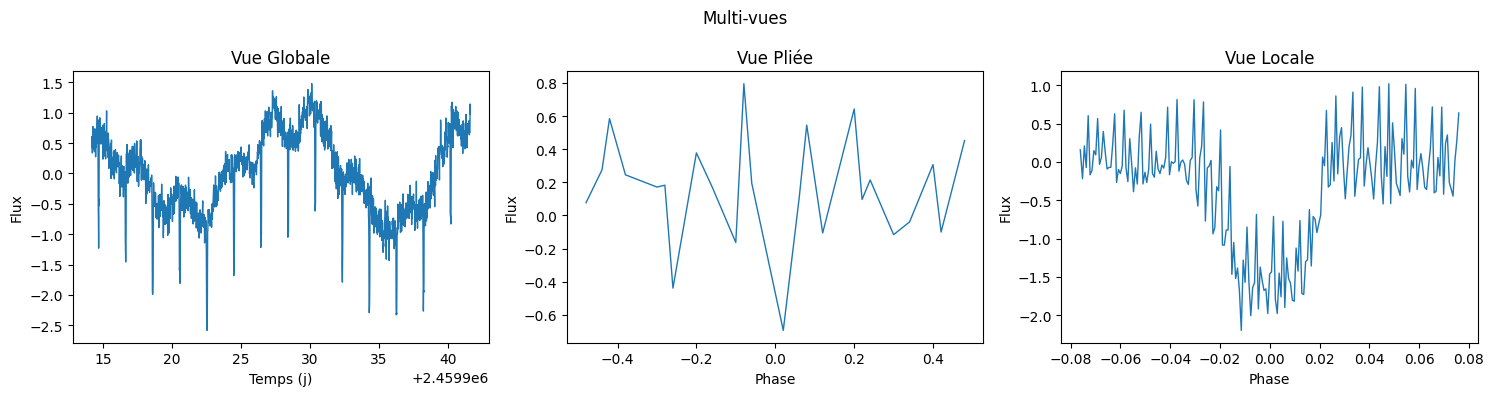

In [33]:
# Suppose: proc existe déjà. Si bls_out existe aussi, on s'en sert pour P,t0,dur (sinon: vues globales seules).
views = build_multires_views(proc, bls_out=globals().get("bls_out", None),
                             N_GLOBAL=2001, N_LOCAL=201, window_factor=2.0)

# (optionnel) Visualisation rapide
plot_multires_views(views, title="Multi-vues")

# (B) Extraction de features TSFRESH (baseline + fusion)

In [34]:
# ============================================
# Pipeline TSFRESH (extraction + sélection + normalisation) — Kaggle-ready
# Hypothèses:
#  - Vous avez déjà: df, cfg, infer_time_flux_columns(...), group_iter(...),
#                    preprocess_single_lightcurve(...), run_bls_on_proc(...) (optionnel)
#  - Objectif: produire un tableau de features par courbe (id de groupe),
#              y ajouter des features astrophysiques (P, dur, depth, snr) si BLS dispo,
#              puis sélectionner les top-K (optionnel, si y est fourni) et normaliser.
# ============================================
import numpy as np, pandas as pd, warnings, hashlib
warnings.filterwarnings("ignore")

# 0) Dépendances TSFRESH
try:
    from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters
    from tsfresh.utilities.dataframe_functions import impute as tsfresh_impute
    from tsfresh.feature_selection import select_features
except Exception as e:
    raise RuntimeError("TSFRESH manquant. Exécutez dans une cellule séparée: !pip -q install tsfresh")

# ---------- Utilitaires ----------
def _gid_to_int(gid: str) -> int:
    """Mappe un identifiant texte de groupe vers un entier stable (pour TSFRESH 'id')."""
    return int(hashlib.md5(gid.encode()).hexdigest()[:8], 16)

def _make_long_df_from_proc(proc: dict, gid: str) -> pd.DataFrame:
    """
    Transforme la série uniformisée d'un groupe en format long pour TSFRESH:
    colonnes: ['id','time','value']
    """
    t = np.asarray(proc["time_uniform"])
    y = np.asarray(proc["flux_uniform"])
    m = np.isfinite(t) & np.isfinite(y)
    df_long = pd.DataFrame({
        "id": _gid_to_int(gid),
        "time": t[m],
        "value": y[m]
    })
    return df_long

def _astrophys_extras_from_bls(bls_out: dict | None) -> dict:
    """
    Extrait quelques indicateurs astrophysiques élémentaires depuis BLS (si dispo).
    """
    extras = {"P": np.nan, "duration": np.nan, "depth": np.nan, "snr_bls": np.nan, "single_transit_like": np.nan}
    if bls_out is None or "results" not in bls_out or len(bls_out["results"]) == 0:
        return extras
    res0 = bls_out["results"].iloc[0]
    extras.update({
        "P": float(res0.get("period", np.nan)),
        "duration": float(res0.get("duration", np.nan)),          # jours
        "depth": float(res0.get("depth", np.nan)),
        "snr_bls": float(res0.get("snr", np.nan)),
        "single_transit_like": float(bool(bls_out["periodogram"].get("single_transit_like", False)))
    })
    return extras

# ---------- Extraction batched ----------
def tsfresh_extract_for_groups(df: pd.DataFrame,
                               cfg,
                               time_col: str | None = None,
                               flux_col: str | None = None,
                               max_groups: int = 10,
                               run_bls: bool = True,
                               bls_params: dict | None = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Boucle sur quelques groupes (id de cible), prétraite -> proc
    2) Construit le long-DF pour TSFRESH et accumulateur de meta (astrophysique)
    3) Extrait les features (~790) via ComprehensiveFCParameters
    4) Retourne: (X_all, meta), indexé par id numérique (stable pour ce df)
    """
    if time_col is None or flux_col is None:
        time_col, flux_col = infer_time_flux_columns(df)

    long_blocks = []
    rows_meta = []

    for i, (gid, sub) in enumerate(group_iter(df)):
        if i >= max_groups:
            break
        sub = sub.sort_values(time_col)
        proc = preprocess_single_lightcurve(sub, time_col, flux_col, cfg)

        # BLS optionnel
        bls_out = None
        if run_bls:
            try:
                bp = bls_params or {}
                bls_out = run_bls_on_proc(proc, **{
                    "n_periods": bp.get("n_periods", 5000),
                    "min_period_hours": bp.get("min_period_hours", 7.0),
                    "max_period_frac_baseline": bp.get("max_period_frac_baseline", 0.9),
                    "durations_hours": bp.get("durations_hours", (1.0, 12.0)),
                    "n_durations": bp.get("n_durations", 10),
                    "top_k": bp.get("top_k", 3)
                })
            except Exception as e:
                print(f"[BLS] Skip {gid}: {e}")

        # Long-format pour TSFRESH
        df_long = _make_long_df_from_proc(proc, gid)
        long_blocks.append(df_long)

        # Meta + features astro simples
        extras = _astrophys_extras_from_bls(bls_out)
        extras.update({
            "id": _gid_to_int(gid),
            "gid": gid,
            "resample_step_minutes": float(proc.get("resample_step_minutes", np.nan)),
            "n_points": int(len(df_long)),
        })
        rows_meta.append(extras)

    if not long_blocks:
        raise RuntimeError("Aucun groupe n'a été traité. Vérifiez vos données/paramètres.")

    long_df = pd.concat(long_blocks, ignore_index=True)
    meta_df = pd.DataFrame(rows_meta).set_index("id").sort_index()

    # TSFRESH extraction (Comprehensive)
    settings = ComprehensiveFCParameters()
    # NOTE: vous pouvez réduire la charge en supprimant des familles de features dans 'settings'
    X = extract_features(
        long_df,
        column_id="id",
        column_sort="time",
        column_value="value",
        default_fc_parameters=settings,
        disable_progressbar=True,
        n_jobs=0  # 0 => séquentiel (plus sûr sur petits kernels)
    )

    # Imputation TSFRESH (remplit NaN/Inf de manière standard)
    tsfresh_impute(X)

    # Concat meta/astro
    for col in meta_df.columns:
        X[col] = meta_df[col].reindex(X.index)

    # Index = id numérique, gardons aussi la colonne texte 'gid' pour traçabilité
    # (déjà incluse ci-dessus via meta_df["gid"])
    return X, meta_df

# ---------- Sélection supervisée (optionnelle) ----------
def tsfresh_supervised_selection(X: pd.DataFrame, y: pd.Series | pd.DataFrame,
                                 fdr_level: float = 0.05, top_k: int | None = 100) -> pd.DataFrame:
    """
    y: Series indexée par 'id' (entier) avec labels 0/1 ou multi-classes.
    - Applique la sélection TSFRESH (tests d'hypothèse + contrôle FDR).
    - Si top_k est spécifié, garde les K meilleures (par p-value croissante).
    """
    # Harmonise les index
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("y DataFrame doit avoir une seule colonne (label).")
        y = y.iloc[:, 0]
    y = y.reindex(X.index)

    X_sel = select_features(X.drop(columns=["gid"], errors="ignore"), y, fdr_level=fdr_level)
    # Ré-attacher 'gid' pour info
    if "gid" in X.columns:
        X_sel["gid"] = X["gid"]

    if top_k is not None and X_sel.shape[1] > top_k + (1 if "gid" in X_sel.columns else 0):
        # Ordre par variance (proxy simple) si p-values non accessibles ici
        non_meta_cols = [c for c in X_sel.columns if c != "gid"]
        var_order = X_sel[non_meta_cols].var().sort_values(ascending=False).index.tolist()
        keep = var_order[:top_k]
        X_sel = X_sel[keep + (["gid"] if "gid" in X_sel.columns else [])]

    return X_sel

# ---------- Normalisation robuste (pour entrée MLP d'embedding) ----------
from sklearn.preprocessing import RobustScaler

def normalize_tsfresh_features(X_sel: pd.DataFrame) -> tuple[np.ndarray, list[str], RobustScaler]:
    """
    Retire 'gid' si présent, fit un RobustScaler, renvoie (X_norm, feature_names, scaler).
    """
    cols = [c for c in X_sel.columns if c != "gid"]
    scaler = RobustScaler()
    X_norm = scaler.fit_transform(X_sel[cols].values.astype(float))
    return X_norm, cols, scaler



In [ ]:
# ---------- EXEMPLE D’USAGE (extrait, mêmes variables) ----------
# 1) détecter colonnes time/flux
time_col, flux_col = infer_time_flux_columns(df)

# 2) extraire features tsfresh (sur quelques groupes pour démo)
X_all, meta = tsfresh_extract_for_groups(
    df, cfg, time_col=time_col, flux_col=flux_col,
    max_groups=5, run_bls=True,
    bls_params=dict(min_period_hours=7.0, max_period_frac_baseline=0.9,
                    durations_hours=(1.0, 12.0), n_durations=10, top_k=3)
)
print("[TSFRESH] Matrice brute:", X_all.shape, "| colonnes (extrait):", X_all.columns[:8].tolist())
print("[TSFRESH] Meta (index=id):")
display(meta.head())

# 3) (optionnel) si vous avez des labels par id (Series y: index=id -> {0,1})
# y = ...  # e.g., pd.Series(..., index=X_all.index)
# X_sel = tsfresh_supervised_selection(X_all, y, fdr_level=0.05, top_k=100)
# print("[TSFRESH] Sélection supervisée:", X_sel.shape)

# Si pas de labels pour le moment, prenez un sous-ensemble de features par variance:
non_meta_cols = [c for c in X_all.columns if c not in ("gid",)]
top_k = 100 if len(non_meta_cols) > 100 else len(non_meta_cols)
var_order = X_all[non_meta_cols].var().sort_values(ascending=False).index.tolist()[:top_k]
X_sel = X_all[var_order + (["gid"] if "gid" in X_all.columns else [])]
print(f"[TSFRESH] Sélection non supervisée ~ top-{top_k} par variance:", X_sel.shape)

# 4) Normalisation robuste pour l'entrée du MLP d'embedding (section fusion tardive)
X_norm, feat_names, scaler = normalize_tsfresh_features(X_sel)
print("[TSFRESH] X_norm prêt pour MLP d'embedding:", X_norm.shape)

# (Optionnel) Sauvegardes pour la suite (Transformer + fusion tardive)
# X_all.to_parquet("tsfresh_all.parquet")
# X_sel.to_parquet("tsfresh_selected.parquet")
# with open("tsfresh_scaler.pkl", "wb") as f:
#     import pickle; pickle.dump(scaler, f)

# NOTE Fusion tardive (implémentation à venir dans la section C):
#  - Dans votre modèle, créez un petit MLP (ex: Dense 256, dropout) qui prend X_norm (K features)
#    et produit un embedding (par ex. shape [batch, 256]).
#  - Concaténez cet embedding avec le token [CLS] (ou le pooling global) du Transformer
#    avant la tête de classification finale. Pensez à régulariser (dropout/L2) la branche tabulaire.


[BLS] Skip target_id=TIC_101230735: The maximum transit duration must be shorter than the minimum period
[BLS] Skip target_id=TIC_106997505: The maximum transit duration must be shorter than the minimum period
[BLS] Skip target_id=TIC_107782586: The maximum transit duration must be shorter than the minimum period
[BLS] Skip target_id=TIC_112395568: The maximum transit duration must be shorter than the minimum period
[BLS] Skip target_id=TIC_114018671: The maximum transit duration must be shorter than the minimum period
